In [1]:
import matplotlib.pyplot as plt
import numpy
import pandas
import functools 
import datetime
import scipy

import pmana.utils

#### Look at one single measurement

There were 4 used channels in this measurement.


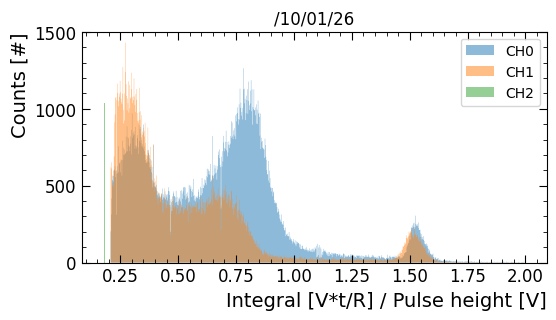

In [2]:
fig, ax = plt.subplots(figsize=(6,3))

MEASUREMENT = '/10/01/26'
# extract a measurement 
Data = pmana.utils.io.ExtractSingleMeasurement(
    f"../../data/cern/2025_Dec{MEASUREMENT}/",
    DELIMITER = ","
)
print(f"There were {len(Data)} used channels in this measurement.")

CHs = [1, 2, 3]
for ch in CHs:
    # plot channel data
    pmana.utils.plotting.PlotSingleChannel(
        Data[ch-1],
        ax,
        channel = ch-1,
        rebin = False,
        debug = False,
        DISPLAY_FIT = False
    )

ax = pmana.utils.plotting.UpdateMatplotlibStyle(
    ax,
    "Integral [V*t/R] / Pulse height [V]",
    "Counts [#]"
)

ax.legend()
ax.set_title(f"{MEASUREMENT}")
plt.show()


#### Calibration

In several campaigns, a test pulse is sent to the channels of each purity monitor. The test pulse serves as a reference, clean, isolated peak (usually, >1 V) we can use to cross-calibrate different channels. Moreover, we can correlate the test pulse trend as function of the temperature to understand the correlation, remove the temperature dependence statistically, and extract the systematic uncertainty on the anode measurements (given that the statistical contribution is negligble for large enough datasets).

In [3]:
TIME_DIR = f"2025_Dec"
PATH_CAMPAIGN = f"../../data/cern/{TIME_DIR}"
PATH_TEMPERATURES = f"../../data/cern/NP02-amb-temp.csv"

In [4]:
# get temperature mapping
Temperatures = pmana.utils.io.ExtractTemperatureMonitoring(
    PATH_TEMPERATURES,
    IsPadova = False,
    delimiter = ",",
    skiprows = 3,
    usecols = [0, 1],
    names = ["Date", "T"],
    parse_dates = ["Date"]
)

In [5]:
# analyze campaign
Output = pmana.utils.anatestdata.IterateCERN(
    PATH_CAMPAIGN,  ###< path to data
    # pmana.utils.anatestdata.AnalyzeMeasurement, 
    functools.partial(pmana.utils.anatestdata.GaussianFitToChannel, 
        IS_DT5781=False, rebin=False, debug=False,
        MASK_TESTPULSE = True, DELIMITER = ',', SKIP_NROWS = 4, BINNAME = 'BinCenter', COUNTNAME = 'Population'),  ###< analyzing module, changing some options 
    YEAR = 2025,
    MONTH = 12
)

# convert top DataFrame
Output = pandas.DataFrame(Output)

In [6]:
# re-format the dataframe
Output.columns = ["Peak_CH1", "Err_Peak_CH1", "Width_CH1", "Err_Width_CH1",
                  "Peak_CH2", "Err_Peak_CH2", "Width_CH2", "Err_Width_CH2", 
                  "Peak_CH3", "Err_Peak_CH3", "Width_CH3", "Err_Width_CH3", 
                  "Date"]

# sort by date
Output.sort_values(
    by = 'Date', 
    inplace = True,
    ignore_index = True
)

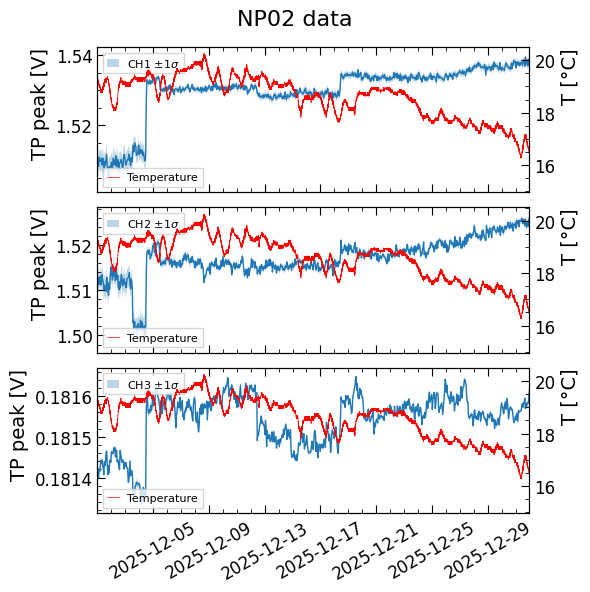

In [394]:
fig, ax = plt.subplots(figsize=(6, 2.*3), nrows=3, layout='tight')

# CH1
ax[0].plot(Output.Date, Output.Peak_CH1, lw=1)
ax[0].fill_between(Output.Date, Output.Peak_CH1-Output.Err_Peak_CH1,  Output.Peak_CH1+Output.Err_Peak_CH1, alpha=0.3, label='CH1 $\\pm1\\sigma$')
pmana.utils.plotting.UpdateMatplotlibStyle(ax[0], None, 'TP peak [V]')
ax[0].set_xticklabels([])

# CH2
ax[1].plot(Output.Date, Output.Peak_CH2, lw=1)
ax[1].fill_between(Output.Date, Output.Peak_CH2-Output.Err_Peak_CH2,  Output.Peak_CH2+Output.Err_Peak_CH2, alpha=0.3, label='CH2 $\\pm1\\sigma$')
pmana.utils.plotting.UpdateMatplotlibStyle(ax[1], None, 'TP peak [V]')
ax[1].set_xticklabels([])

# CH3
ax[2].plot(Output.Date, Output.Peak_CH3.astype(float), lw=1)
ax[2].fill_between(Output.Date, Output.Peak_CH3-Output.Err_Peak_CH3,  Output.Peak_CH3+Output.Err_Peak_CH3, alpha=0.3, label='CH3 $\\pm1\\sigma$')
pmana.utils.plotting.UpdateMatplotlibStyle(ax[2], None, 'TP peak [V]')
# ax[2].set_xticklabels([])

for a in ax:
    # gfx
    a.legend(frameon=True, fancybox=False, handlelength=1, fontsize=8, loc='upper left')
    a.tick_params(axis='x', labelrotation=30)
    a.set_xlim(Output['Date'].iloc[0], Output['Date'].iloc[-1])

    # plot temperatures
    a2 = a.twinx()
    a2.plot(Temperatures['Date'], Temperatures['T'], c='red', label='Temperature', lw=0.5, zorder=-3)
    pmana.utils.plotting.UpdateMatplotlibStyle(a2, None, 'T [°C]')
    a2.legend(frameon=True, fancybox=False, handlelength=1, fontsize=8, loc='lower left')

fig.suptitle(f'NP02 data', fontsize=16)

plt.show()
fig.savefig(f"../../plots/cern/Calibration_TestPulseTrend_{TIME_DIR}.png", dpi=300, bbox_inches='tight')

### Temperature dependence

By interpolating the temperature trend, we can carry out a complete voltage-temperature correlation study.

To study the correlation, keep in mind that:
* using a large period of time could introduce fake correlations;
* using a small period of time introduces more statistical fluctuations in the procedure, and often won't capture temperature changes (e.g., daily fluctuations).

In [47]:
# Interpolate temperatures to generalize
Temperatures['Date_s'] = Temperatures["Date"].astype("int64") / 1e9 ###< seconds from epoch, 1970-01-01
Output['Date_s'] = Output["Date"].astype("int64") / 1e9

TempVsTime = scipy.interpolate.interp1d(
  Temperatures['Date_s'],
  Temperatures['T'],
  kind = 'linear'
)
Output['T'] = TempVsTime(Output['Date_s'])

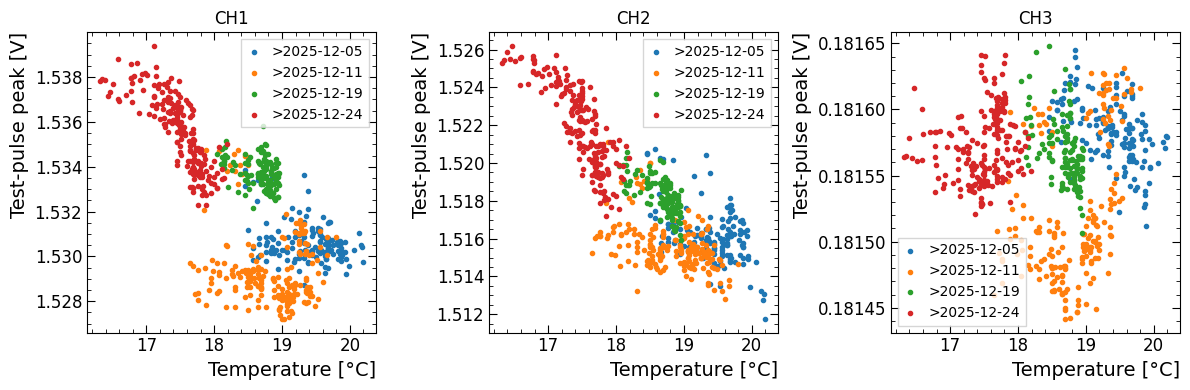

In [110]:
fig, axes = plt.subplots(figsize=(4*3, 4), ncols=3, layout='tight')

DateLowLimits = [
  datetime.datetime(2025, 12, 5),
  datetime.datetime(2025, 12, 11),
  datetime.datetime(2025, 12, 19),
  datetime.datetime(2025, 12, 24)
]

for i in range(len(DateLowLimits)):

  LowDate = DateLowLimits[i]
  
  if i+1 == len(DateLowLimits):
    HighDate = datetime.datetime(2026, 1, 1)
  else:
    HighDate = DateLowLimits[i+1]

  for i, ax in enumerate(axes):
    Mask = (Output['Date'] > LowDate) & (Output['Date'] < HighDate)
    ax.scatter(Output[Mask]['T'], Output[Mask][f'Peak_CH{i+1}'], marker = '.', label=f'>{LowDate.strftime('%Y-%m-%d')}')
    
    pmana.utils.plotting.UpdateMatplotlibStyle(ax, f'Temperature [°C]', f'Test-pulse peak [V]')
    ax.set_title(f'CH{i+1}')

plt.show()

In [176]:
def linear(T, a, b):
    return a*T + b

def quadratic(T, a, b, c):
    return a*T**2 + b*T + c

# bands from covariances
def linear_band(T, cov):
    da2 = cov[0, 0]
    db2 = cov[1, 1]
    dab = cov[0, 1]
    return numpy.sqrt(T**2 * da2 + db2 + 2*T*dab)

def quadratic_band(T, cov):
    var = (
        (T**2)**2 * cov[0, 0] +
        T**2 * cov[1, 1] +
        cov[2, 2] +
        2*T**3 * cov[0, 1] +
        2*T**2 * cov[0, 2] +
        2*T * cov[1, 2]
    )
    return numpy.sqrt(var)

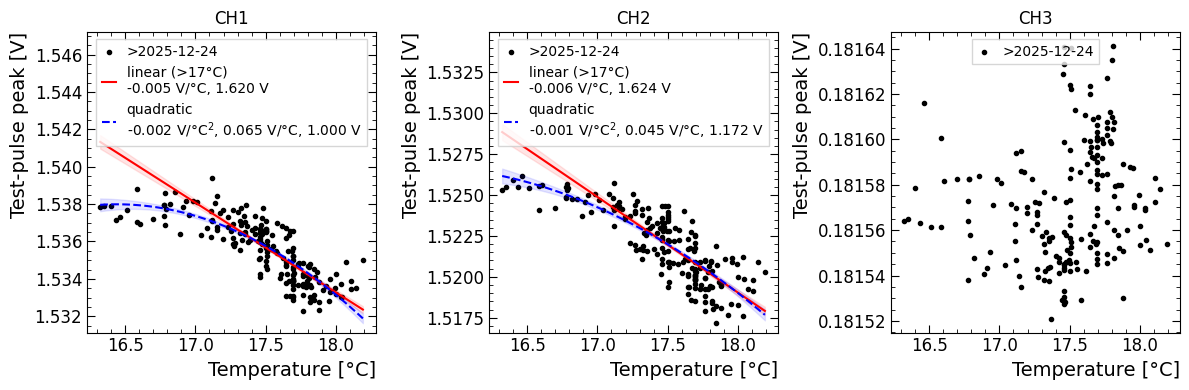

In [343]:
fig, axes = plt.subplots(figsize=(4*3, 4), ncols=3, layout='tight')

LowDate = datetime.datetime(2025, 12, 24)
Mask = (Output['Date'] > LowDate) 

LinearCalibration = []
QuadraticCalibration = []

for i, ax in enumerate(axes):

  # scatter
  ax.scatter(Output[Mask]['T'], Output[Mask][f'Peak_CH{i+1}'], marker = '.', c='black', label=f'>{LowDate.strftime('%Y-%m-%d')}')
  
  # fits
  if i != 2:
    x = Output[Mask]['T'].values
    y = Output[Mask][f'Peak_CH{i+1}'].values

    # linear
    par, cov = scipy.optimize.curve_fit(linear, x[x > 17], y[x > 17]); LinearCalibration.append(par)
    domain = numpy.linspace(min(x), max(x), 100)
    ax.plot(domain, linear(domain, *par), c='red', lw=1.5, 
            label=f'linear (>17°C)\n{par[0]:.3f} V/°C, {par[1]:.3f} V')
    err_lin = linear_band(domain, cov)
    ax.fill_between(domain, linear(domain, *par) - err_lin, linear(domain, *par) + err_lin, color='red', alpha=0.1)
    
    # poly
    parpoly, covpoly = scipy.optimize.curve_fit(quadratic, x, y); QuadraticCalibration.append(parpoly)
    ax.plot(domain, quadratic(domain, *parpoly), c='blue', lw=1.5, ls='--', 
            label=f'quadratic\n{parpoly[0]:.3f} V/°C$^2$, {parpoly[1]:.3f} V/°C, {parpoly[2]:.3f} V')
    err_lin = quadratic_band(domain, covpoly)
    ax.fill_between(domain, quadratic(domain, *parpoly) - err_lin, quadratic(domain, *parpoly) + err_lin, color='blue', alpha=0.1)
    
  pmana.utils.plotting.UpdateMatplotlibStyle(ax, f'Temperature [°C]', f'Test-pulse peak [V]')
  ax.legend(loc='upper center', fancybox=False, handlelength=1)
  if i != 2:
    ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1]+0.005)
  ax.set_title(f'CH{i+1}')

plt.show()

In [395]:
def ApplyCalibration(peak, T, par, mode='linear'):

  if mode == 'linear':
    if len(par) != 2:
      raise Exception(f'Cannot apply {mode} calibration with {len(par)} fit parameters.')

    a, b = par
    fT  = a*T  + b
    fT0 = a*T[0] + b

  elif mode == 'quadratic':

    if len(par) != 3:
      raise Exception(f'Cannot apply {mode} calibration with {len(par)} fit parameters.')
    
    a, b, c = par
    fT  = a*T**2  + b*T  + c
    fT0 = a*T[0]**2 + b*T[0] + c

  else:
    raise ValueError(f'Unknown calibration mode: {mode}')
  
  peak_calibrated = peak - (fT - fT0)

  return peak_calibrated

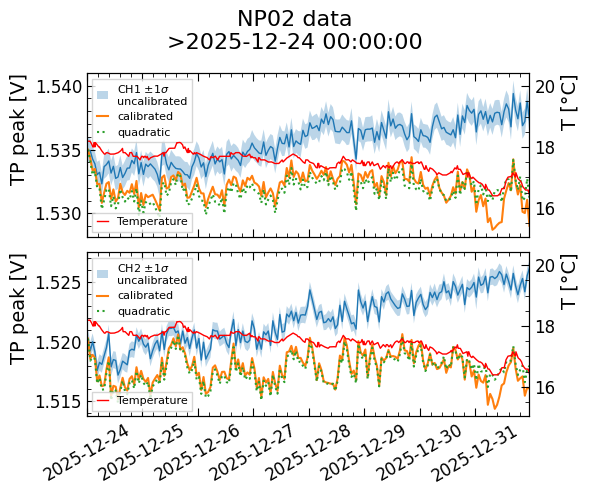

In [412]:
fig, ax = plt.subplots(figsize=(6, 2.5*2), nrows=2, layout='tight')

LowDate = datetime.datetime(2025, 12, 24)
Mask = (Output.Date > LowDate)
OutputMasked = Output[Mask].copy()

# the time range is important: you need a reference temperature
OutputMasked['Peak_CH1_Cal'] = ApplyCalibration(
  OutputMasked['Peak_CH1'].values,
  OutputMasked['T'].values,
  LinearCalibration[0]
)

OutputMasked['Peak_CH2_Cal'] = ApplyCalibration(
  OutputMasked['Peak_CH2'].values,
  OutputMasked['T'].values,
  LinearCalibration[1]
)

# quadratic calibration
OutputMasked['Peak_CH1_Cal_Poly'] = ApplyCalibration(
  OutputMasked['Peak_CH1'].values,
  OutputMasked['T'].values,
  QuadraticCalibration[0],
  'quadratic'
)

OutputMasked['Peak_CH2_Cal_Poly'] = ApplyCalibration(
  OutputMasked['Peak_CH2'].values,
  OutputMasked['T'].values,
  QuadraticCalibration[1],
  'quadratic'
)

# CH1
ax[0].plot(OutputMasked.Date, OutputMasked.Peak_CH1, lw=1)
ax[0].fill_between(OutputMasked.Date, OutputMasked.Peak_CH1-OutputMasked.Err_Peak_CH1,  OutputMasked.Peak_CH1+OutputMasked.Err_Peak_CH1, alpha=0.3, label='CH1 $\\pm1\\sigma$\nuncalibrated')
ax[0].plot(OutputMasked.Date, OutputMasked.Peak_CH1_Cal, lw=1.5, label='calibrated')
ax[0].plot(OutputMasked.Date, OutputMasked.Peak_CH1_Cal_Poly, lw=1.5, ls=':', label='quadratic')
pmana.utils.plotting.UpdateMatplotlibStyle(ax[0], None, 'TP peak [V]')
ax[0].set_xticklabels([])

# CH2
ax[1].plot(OutputMasked.Date, OutputMasked.Peak_CH2, lw=1)
ax[1].fill_between(OutputMasked.Date, OutputMasked.Peak_CH2-OutputMasked.Err_Peak_CH2,  OutputMasked.Peak_CH2+OutputMasked.Err_Peak_CH2, alpha=0.3, label='CH2 $\\pm1\\sigma$\nuncalibrated')
ax[1].plot(OutputMasked.Date, OutputMasked.Peak_CH2_Cal, lw=1.5, label='calibrated')
ax[1].plot(OutputMasked.Date, OutputMasked.Peak_CH2_Cal_Poly, lw=1.5, ls=':', label='quadratic')
pmana.utils.plotting.UpdateMatplotlibStyle(ax[1], None, 'TP peak [V]')

for a in ax:
    # gfx
    a.legend(frameon=True, fancybox=False, handlelength=1, fontsize=8, loc='upper left')
    a.tick_params(axis='x', labelrotation=30)
    a.set_xlim(LowDate, Output['Date'].iloc[-1])

    # plot temperatures
    a2 = a.twinx()
    a2.plot(Temperatures['Date'][::10], Temperatures['T'][::10], c='red', label='Temperature', zorder=-3, lw=1)
    pmana.utils.plotting.UpdateMatplotlibStyle(a2, None, 'T [°C]')
    a2.legend(frameon=True, fancybox=False, handlelength=1, fontsize=8, loc='lower left')

fig.suptitle(f'NP02 data\n>{LowDate}', fontsize=16)

plt.show()

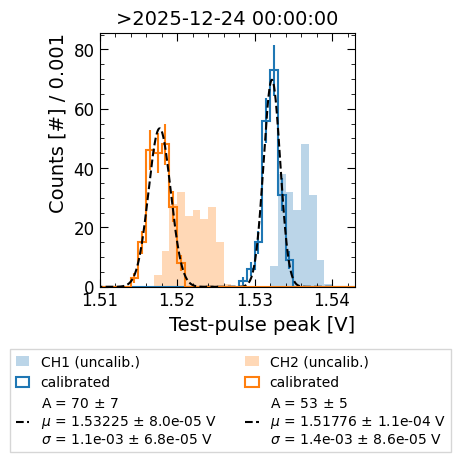

In [366]:
fig, ax = plt.subplots(figsize=(3.3, 3.3))

width = 0.001; binning = numpy.arange(1.51, 1.543+width, width)
LowDate = datetime.datetime(2025, 12, 24)
Mask = (Output.Date > LowDate)
OutputMasked = Output[Mask].copy()

# the time range is important: you need a reference temperature
OutputMasked['Peak_CH1_Cal'] = ApplyCalibration(
  OutputMasked['Peak_CH1'].values,
  OutputMasked['T'].values,
  LinearCalibration[0]
)

OutputMasked['Peak_CH2_Cal'] = ApplyCalibration(
  OutputMasked['Peak_CH2'].values,
  OutputMasked['T'].values,
  LinearCalibration[1]
)

# CH1
ax.hist(OutputMasked.Peak_CH1, bins=binning, histtype='stepfilled', fc='C0', alpha=0.3, label='CH1 (uncalib.)')

# CH1 -- calibrated
counts, edges, _ = ax.hist(OutputMasked.Peak_CH1_Cal, bins=binning, histtype='step', linewidth=1.5, color='C0', label='calibrated')
x = 0.5 * (edges[:-1] + edges[1:])
ax.errorbar(x, counts, yerr=numpy.sqrt(counts), c='C0', marker='', ls='')

# fit
p0 = [max(counts), numpy.mean(OutputMasked.Peak_CH1_Cal), numpy.std(OutputMasked.Peak_CH1_Cal)]
par, cov = scipy.optimize.curve_fit(
  pmana.utils.fitting.Gaus, 
  x[counts > 0], counts[counts > 0], 
  p0=p0, 
  sigma=numpy.sqrt(counts[counts > 0]), absolute_sigma=True
)
err = numpy.sqrt(numpy.diag(cov))
dom = numpy.linspace(min(OutputMasked.Peak_CH1_Cal)-0.005, max(OutputMasked.Peak_CH1_Cal)+0.005, 1000)
ax.plot(dom, pmana.utils.fitting.Gaus(dom, *par), lw=1.5, ls='--', c='black',
        label = f'A = {par[0]:.0f} $\\pm$ {err[0]:.0f}\n$\\mu$ = {par[1]:.5f} $\\pm$ {err[1]:.1e} V\n$\\sigma$ = {par[2]:.1e} $\\pm$ {err[2]:.1e} V')

# CH2
ax.hist(OutputMasked.Peak_CH2, bins=binning, histtype='stepfilled', fc='C1', alpha=0.3, label='CH2 (uncalib.)')

# CH2 -- calibrated
counts, edges, _ = ax.hist(OutputMasked.Peak_CH2_Cal, bins=binning, histtype='step', linewidth=1.5, color='C1', label='calibrated')
x = 0.5 * (edges[:-1] + edges[1:])
ax.errorbar(x, counts, yerr=numpy.sqrt(counts), c='C1', marker='', ls='')

# fit
p0 = [max(counts), numpy.mean(OutputMasked.Peak_CH2_Cal), numpy.std(OutputMasked.Peak_CH2_Cal)]
par, cov = scipy.optimize.curve_fit(
  pmana.utils.fitting.Gaus, 
  x[counts > 0], counts[counts > 0], 
  p0=p0, 
  sigma=numpy.sqrt(counts[counts > 0]), absolute_sigma=True
)
err = numpy.sqrt(numpy.diag(cov))
dom = numpy.linspace(min(OutputMasked.Peak_CH2_Cal)-0.005, max(OutputMasked.Peak_CH2_Cal)+0.005, 1000)
ax.plot(dom, pmana.utils.fitting.Gaus(dom, *par), lw=1.5, ls='--', c='black', 
        label = f'A = {par[0]:.0f} $\\pm$ {err[0]:.0f}\n$\\mu$ = {par[1]:.5f} $\\pm$ {err[1]:.1e} V\n$\\sigma$ = {par[2]:.1e} $\\pm$ {err[2]:.1e} V')

# gfx
pmana.utils.plotting.UpdateMatplotlibStyle(ax, 'Test-pulse peak [V]', f'Counts [#] / {width}')
ax.legend(loc=(-0.35, -0.65), handlelength=1, ncol=2, fancybox=False)
ax.set_xlim(binning[0], binning[-1])
ax.set_title(f'>{LowDate}', fontsize=14)

plt.show()

In [399]:
100 * 8e-5 / 1.53225, 100 * 1.1e-4 / 1.51776

(0.0052210801109479526, 0.007247522664979971)

In [400]:
100 * 1.1e-3 / 1.53225, 100 * 1.4e-3 / 1.51776

(0.07178985152553435, 0.09224119755429053)

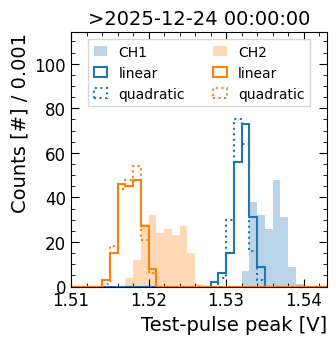

In [392]:
fig, ax = plt.subplots(figsize=(3.3, 3.3))

width = 0.001; binning = numpy.arange(1.51, 1.543+width, width)
LowDate = datetime.datetime(2025, 12, 24)
Mask = (Output.Date > LowDate)
OutputMasked = Output[Mask].copy()

# the time range is important: you need a reference temperature
OutputMasked['Peak_CH1_Cal'] = ApplyCalibration(
  OutputMasked['Peak_CH1'].values,
  OutputMasked['T'].values,
  LinearCalibration[0]
)

OutputMasked['Peak_CH2_Cal'] = ApplyCalibration(
  OutputMasked['Peak_CH2'].values,
  OutputMasked['T'].values,
  LinearCalibration[1]
)

# quadratic calibration
OutputMasked['Peak_CH1_Cal_Poly'] = ApplyCalibration(
  OutputMasked['Peak_CH1'].values,
  OutputMasked['T'].values,
  QuadraticCalibration[0],
  'quadratic'
)

OutputMasked['Peak_CH2_Cal_Poly'] = ApplyCalibration(
  OutputMasked['Peak_CH2'].values,
  OutputMasked['T'].values,
  QuadraticCalibration[1],
  'quadratic'
)

# CH1
ax.hist(OutputMasked.Peak_CH1, bins=binning, histtype='stepfilled', color='C0', alpha=0.3, label='CH1')
counts, edges, _ = ax.hist(OutputMasked.Peak_CH1_Cal, bins=binning, histtype='step', linewidth=1.5, color='C0', label='linear')
counts, edges, _ = ax.hist(OutputMasked.Peak_CH1_Cal_Poly, bins=binning, histtype='step', linestyle=':', linewidth=1.5, color='C0', label='quadratic')

# CH2
ax.hist(OutputMasked.Peak_CH2, bins=binning, histtype='stepfilled', color='C1', alpha=0.3, label='CH2')
counts, edges, _ = ax.hist(OutputMasked.Peak_CH2_Cal, bins=binning, histtype='step', linewidth=1.5, color='C1', label='linear')
counts, edges, _ = ax.hist(OutputMasked.Peak_CH2_Cal_Poly, bins=binning, histtype='step', linestyle=':', linewidth=1.5, color='C1', label='quadratic')

# gfx
pmana.utils.plotting.UpdateMatplotlibStyle(ax, 'Test-pulse peak [V]', f'Counts [#] / {width}')
ax.legend(loc='upper center', fontsize=10, handlelength=1, ncol=2, fancybox=False)
ax.set_ylim(0, max(counts+60))
ax.set_xlim(binning[0], binning[-1])
ax.set_title(f'>{LowDate}', fontsize=14)

plt.show()